# CVXOPTで２次計画問題を解く〜ポートフォリオ最適化の例〜

CVXOPTは凸最適化問題を解くフリーのライブラリです．

今回は，ポートフォリオ最適化を例にして，CVXOPTで２次計画問題を実装してみます．

## 準備

### CVXOPTをインストールする

[CVXOPT Installation instructions](http://cvxopt.org/install/index.html)
を参考にしてください．

In [ ]:
pip install cvxopt

### データの準備

今回用いるCVXOPT以外のライブラリをインポートします．

In [1]:
#from math import sqrt
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
%matplotlib inline

今回の例では，Kenneth R. French教授のData Libraryの30業種ポートフォリオのデータを用います．

[Kenneth R. Frenchデータライブラリ](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

In [2]:
name = '30_Industry_Portfolios'
df_dict = pdr.DataReader(name=name, data_source='famafrench')
df = df_dict[0]

期待リターン(収益率)を計算します．

In [3]:
mean = df.mean()

リスク(分散共分散行列)を計算します．

In [4]:
cov = df.cov()
std = np.sqrt(np.diag(cov))

各資産を標準偏差と期待リターンでプロットし，シャープレシオ(リスクフリーレートは考慮しない)で色付けします．

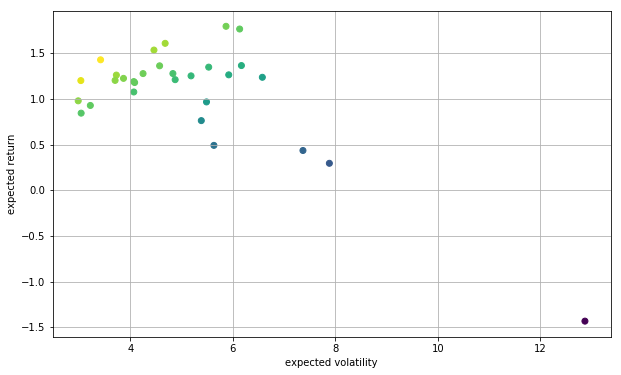

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(std, mean, c=mean/std, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

## CVXOPTで二次計画問題を解く

### H.M.Markowitzの平均・分散モデル

<img src=port_qp.png>

### cvxopt.solvers.qp()を使う

In [6]:
from cvxopt import matrix
from cvxopt.solvers import qp

[CVXOPT Quadratic Programming](http://cvxopt.org/userguide/coneprog.html#quadratic-programming)
を確認すると，qpの引数はP, q, G, h, A, bがあります．よって，ポートフォリオ最適化問題を以下の形式に整理して，行列を求める必要があります．その分，SciPyより手間がかかります．

\begin{align}
\min \quad & \frac{1}{2} {\bf x}^T P {\bf x} + {\bf q}^T {\bf x} \\
{\rm subject \: to} \quad & G {\bf x} \leq {\bf h} \\
& A {\bf x} = {\bf b} \\
\end{align}

### 目標リターン：自分で決める

目標リターンを設定します．
目標リターンは，投資家が恣意的に決めますが，今回は個々の資産の期待リターンの水準を参考に決めます．

In [7]:
tret = mean.mean()  # e.g.: tret = 0.5

### 目的関数

目的関数はポートフォリオの分散なので，Pは分散共分散行列になります．cvxopt.solvers.qpの引数はcvxopt.matrix型にする必要があります．

In [8]:
P = matrix(np.array(cov))

目的関数はポートフォリオの分散なので，qはすべての要素が0の列ベクトルです．なお，「0」とするとmatrixのtc='i'の整数となってしまうため，「0.0」としてtc='d'となるようにします．

In [9]:
q = matrix([0.0] * len(mean))

### 制約条件

Aとbは投資比率の和が1となる等式制約に当たります．Aは要素がすべて1.0の行ベクトルになります．

In [10]:
A = matrix(1.0, (1, len(mean)))

投資比率の和が1なので，bは1.0です．

In [11]:
b = matrix(1.0)

不等式制約はポートフォリオの期待リターンが目標リターン以上となる制約と下限制約にあたります．$G$は以下のようになります．

\begin{eqnarray}
  G = \left(
\begin{array}{ccc}
1 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & 1 \\
-r_1 & \cdots & -r_n
\end{array}
  \right)
\end{eqnarray}

In [12]:
G = matrix(np.c_[-np.identity(len(mean)), np.array(-mean)].T)

hは下限0と目標リターン$r_G$の列ベクトルになります．

$$h=(0,\cdots,0,-r_G)^T$$

In [13]:
h = matrix(np.r_[np.zeros(len(mean)), np.array(-tret, ndmin=1)])

まとめると，次のようになります．

In [14]:
tret = mean.mean()
P = matrix(np.array(cov))
q = matrix([0.0] * len(mean))
A = matrix(1.0, (1, len(mean)))
b = matrix(1.0)
G = matrix(np.c_[-np.identity(len(mean)), np.array(-mean)].T)
h = matrix(np.r_[np.zeros(len(mean)), np.array(-tret, ndmin=1)])

### 最適化

最適化を実行します．

In [15]:
%%time
sol = qp(P=P, q=q, G=G, h=h, A=A, b=b)

     pcost       dcost       gap    pres   dres
 0:  1.9211e+00  1.3849e+00  5e+01  6e+00  2e+01
 1:  2.2276e+00  1.8570e+00  7e+00  9e-01  2e+00
 2:  2.9679e+00  2.7243e+00  2e+00  2e-01  4e-01
 3:  3.2479e+00  3.1472e+00  2e-01  1e-02  3e-02
 4:  3.2302e+00  3.2133e+00  2e-02  3e-04  8e-04
 5:  3.2202e+00  3.2188e+00  1e-03  9e-06  2e-05
 6:  3.2192e+00  3.2191e+00  1e-04  5e-08  1e-07
 7:  3.2191e+00  3.2191e+00  9e-06  4e-11  1e-10
 8:  3.2191e+00  3.2191e+00  3e-07  2e-13  4e-13
Optimal solution found.
CPU times: user 5.65 ms, sys: 4.31 ms, total: 9.96 ms
Wall time: 18.8 ms


最適投資比率を確認します．

In [16]:
list(sol['x'])

[0.08102582818011099,
 0.18117580350450893,
 2.2052601958051202e-10,
 2.791473818233822e-10,
 2.3107093599012332e-10,
 0.2235805616660585,
 2.1444947893347337e-05,
 0.0429951541646363,
 2.244672059887378e-10,
 1.576811647356438e-10,
 2.2223707005360278e-10,
 1.593828339444295e-10,
 2.2480204747889163e-10,
 2.5436816569490545e-10,
 2.3757218306833857e-10,
 7.245791200101394e-10,
 1.0960614720006523e-09,
 2.8289594757143084e-10,
 8.17793744887795e-10,
 0.2703630276982489,
 4.775847959235986e-10,
 7.165009657765875e-10,
 3.887935533418998e-10,
 2.8978444779476304e-10,
 6.20164316805808e-10,
 3.2022559431358423e-09,
 1.030499621608577e-09,
 0.20083816399777873,
 3.11614176673406e-09,
 8.664535479005866e-10]

最適値(ポートフォリオの分散)を確認します．

In [17]:
2 * sol['primal objective']

6.438220501299367

### 効率的フロンティアを描く

目標リターンを複数パターン作ります．

In [18]:
mean_high = mean.max().round(3)
mean_low = round(mean.quantile(0.25), 3)
trets = np.linspace(mean_low, mean_high, 50)

各目標リターンについて，最適化を実行します．

In [19]:
%time
tvols = []
for tret in trets:
    h = matrix(np.r_[np.zeros(len(mean)), np.array(-tret, ndmin=1)])
    sol = qp(P=P, q=q, G=G, h=h, A=A, b=b)
    tvols.append(np.sqrt(2 * sol['primal objective']))
tvols = np.array(tvols)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
     pcost       dcost       gap    pres   dres
 0:  1.9184e+00  1.2664e+00  5e+01  7e+00  2e+01
 1:  2.2018e+00  1.7737e+00  7e+00  1e+00  2e+00
 2:  2.9262e+00  2.6951e+00  2e+00  2e-01  4e-01
 3:  3.2282e+00  3.1416e+00  2e-01  2e-02  4e-02
 4:  3.2285e+00  3.2124e+00  2e-02  8e-04  2e-03
 5:  3.2201e+00  3.2188e+00  2e-03  3e-05  7e-05
 6:  3.2191e+00  3.2191e+00  7e-05  3e-07  6e-07
 7:  3.2191e+00  3.2191e+00  7e-06  2e-09  3e-09
 8:  3.2191e+00  3.2191e+00  4e-07  1e-16  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9187e+00  1.2838e+00  5e+01  7e+00  2e+01
 1:  2.2054e+00  1.7851e+00  7e+00  1e+00  2e+00
 2:  2.9296e+00  2.6965e+00  2e+00  2e-01  4e-01
 3:  3.2303e+00  3.1427e+00  2e-01  2e-02  4e-02
 4:  3.2286e+00  3.2124e+00  2e-02  7e-04  2e-03
 5:  3.2201e+00  3.2188e+00  2e-03  3e-05  6e-05
 6:  3.2191e+00  3.2191e+00  7e-05  3e-07  6e-07
 7:  3.2191e+00  3.2191e+00 

効率的フロンティアを描きます．

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')

### SciPyとの比較

決定変数30個だけですが，CVXOPTのほうがかなり速いです．

| 計測方法 |SciPy  |CVXOPT  |
|---|---|---|
|%%time |  65.8ms|  6.16ms|
|%%timeit |  44.6ms|  4.49ms|

## 参考

- [CVXOPT User's Guide](http://cvxopt.org/userguide/index.html)